In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from __init__ import *

utils.rng.set_seed()
device = utils.gpu.set_devices(3)

In [3]:
# Import data
train = datasets.get_mnist('balanced')
test = datasets.get_mnist('balanced', train=False)

# Get data parameters
N = len(train)
M = np.prod(train.size)

# Create index matrix
index_matrix = torch.eye(len(train.classes)).to(device)

# Set training parameters and loader
batch_size = 32
epochs = 24
nu = 0.00025
loader = torch.utils.data.DataLoader(
    train, batch_size=batch_size, shuffle=True, pin_memory=True
)

# Initialize experiment dictionaries
loss_trace = {}
nets = {}
opts = {}

# Set experiment name
experiment_name = 'pie_dense_classification_var_full'

In [4]:
class VPIEFullClassifier(nn.Module):
    
    def __init__(self, patch_dims, grid_dims, var_dims, classes, splitters, **kwargs):
        super().__init__()
        self.dims_patch = patch_dims
        self.dims_grid = grid_dims
        self.dims_var = var_dims
        self.classes = classes
        
        dct_mixer = OrderedDict({
            'S1': splitters[0], # Splits into patches for mixer
            'C': models.dense.AdjointDenseMixer(patch_dims, grid_dims, **kwargs),
            'S2': splitters[1], # Unsplits and flattens for VPIE
        })
        self.M = modules.AdjointSequential(dct_mixer)
        
        self.C = models.dense.AdjointDense(
            [classes for v in var_dims], 
            stochastic=True, 
            **kwargs
        )

        self.V = models.dense.ConditionalAdjointDense(
            [v - classes for v in var_dims],
            classes,
            stochastic=True,
            f = modules.InvertibleID(),
            **kwargs
        )
        
        self.WDT = modules.DirichletSoftmax(classes, alpha=1.4, **kwargs)        
        
    def forward(self, input, *args, sample=True, **kwargs):
        a = self.M(input)
        yz, mu1, lv1 = self.C(a[:,:self.classes])
        y, S = self.WDT(yz)
        z, mu2, lv2 = self.V(a[:,self.classes:], y, sample=sample)
        mu = torch.cat((mu1, mu2), dim=-1)
        lv = torch.cat((lv1, lv2), dim=-1)
        return y, z, yz, S, mu, lv
            
    def T(self, y, z, yz=None, S=None, *args, **kwargs):
        if yz is None:
            yz = self.WDT.T(y, S)
        
        a = torch.cat((
            self.C.T(yz),
            self.V.T(z, y),
        ), dim=-1)
            
        return self.M.T(a)
        

In [5]:
class VAEFullClassifier(nn.Module):
    
    def __init__(self, patch_dims, grid_dims, var_dims, classes, splitters, **kwargs):
        super().__init__()
        self.dims_patch = patch_dims
        self.dims_grid = grid_dims
        self.dims_var = var_dims
        self.classes = classes
        
        # Only types differ from VPIEFullClassifier, can easily be simplified...
        
        dct_mixer = OrderedDict({
            'S1': splitters[0], # Splits into patches for mixer
            'C': models.dense.AEDenseMixer(patch_dims, grid_dims, **kwargs),
            'S2': splitters[1], # Unsplits and flattens for VAE
        })
        self.M = modules.AdjointSequential(dct_mixer)
        
        self.C = models.dense.AEDense(
            [classes for v in var_dims], 
            stochastic=True, 
            **kwargs
        )

        self.V = models.dense.ConditionalAEDense(
            [v - classes for v in var_dims],
            classes,
            stochastic=True,
            f = modules.InvertibleID(),
            **kwargs
        )
        
        self.WDT = modules.DirichletSoftmax(classes, alpha=1.4, **kwargs)        
        
    def forward(self, input, *args, sample=True, **kwargs):
        a = self.M(input)
        yz, mu1, lv1 = self.C(a[:,:self.classes])
        y, S = self.WDT(yz)
        z, mu2, lv2 = self.V(a[:,self.classes:], y, sample=sample)
        mu = torch.cat((mu1, mu2), dim=-1)
        lv = torch.cat((lv1, lv2), dim=-1)
        return y, z, yz, S, mu, lv
            
    def T(self, y, z, yz=None, S=None, *args, **kwargs):
        if yz is None:
            yz = self.WDT.T(y, S)
        
        a = torch.cat((
            self.C.T(yz),
            self.V.T(z, y),
        ), dim=-1)
            
        return self.M.T(a)
        

In [6]:
# Initialize dimensions, models, parameters and optimizers
patch_dims = [784, 784, 196, 196, 196, 49, 49]
grid_dims =  [1, 1, 4, 4, 4, 16, 16]
var_dims = [784, 2048, 784]

patch_dims_ae = [784, 196, 196, 196, 49]
grid_dims_ae =  [1, 4, 4, 4, 16]
var_dims_ae = [784, 1369, 784]


splitter = modules.AdjointSequential(
    modules.AdjointPatchSplitter((1, 1), (28, 28)),
    modules.AdjointFlatten(-2, -1, (1, 1))
)

unsplitter = modules.AdjointSequential(
    modules.AdjointUnflatten(-2, -1, (4, 4)),
    modules.AdjointPatchUnsplitter((4, 4), (7, 7)),
    modules.AdjointFlatten(-3, -1, (1, 28, 28)),
)

model_kwargs = {
    'activation': modules.BiCELU,
    'activation_params': {},
    'device': device
}

nets = {
    "PIE":  VPIEFullClassifier(
        patch_dims,
        grid_dims,
        var_dims,
        47,
        (splitter, unsplitter),
        **model_kwargs
    ),
    "AE":  VAEFullClassifier(
        patch_dims_ae,
        grid_dims_ae,
        var_dims_ae,
        47,
        (splitter, unsplitter),
        **model_kwargs
    )
}

for k, model in nets.items():
    loss_trace[k] = {}
    opts[k] = torch.optim.Adam(model.parameters() , lr=nu)

In [7]:
# Define objective function

def objective_function(x, xh, y, yh, mu, lv, params=None, alpha=12.0, l2_lambda=1e-6, beta=48.0, reduction='mean'):
    losses = {}

    if params is not None:
        losses['l2'] = torch.tensor(0.).to(x.device)
        for param in params:
            losses['l2'] += torch.norm(param)
        losses['l2'] *= l2_lambda
    
    losses['lx'] = utils.loss.logcosh(xh, x, alpha=alpha, reduction=reduction)    
    losses['ly'] = F.binary_cross_entropy(yh, y, reduction=reduction)    
    losses['kl'] = beta * utils.loss.kl_divergence(mu, lv, reduction=reduction, total_size=len(train))
    losses['l'] = sum(losses.values())
    return losses['l'], losses

In [8]:
# Print no. parameters
print("Number of Parameters:")
for k in nets.keys():
    print(f"No. params {k:5}:  {utils.metrics.no_parameters(nets[k])}")

Number of Parameters:
No. params PIE  :  5458635
No. params AE   :  5600845


In [9]:
# Set examples for training, testing and visualization
sample_indices_small = np.array([0, 3, 42, 85, 666, 1001, 6969, 31415])

# Convert sample indices to tensors
xims = torch.tensor(train.data[sample_indices_small]).float() / 255
xs = xims[:,None,...].to(device)
xt = torch.tensor(test.data).float().to(device) / 255

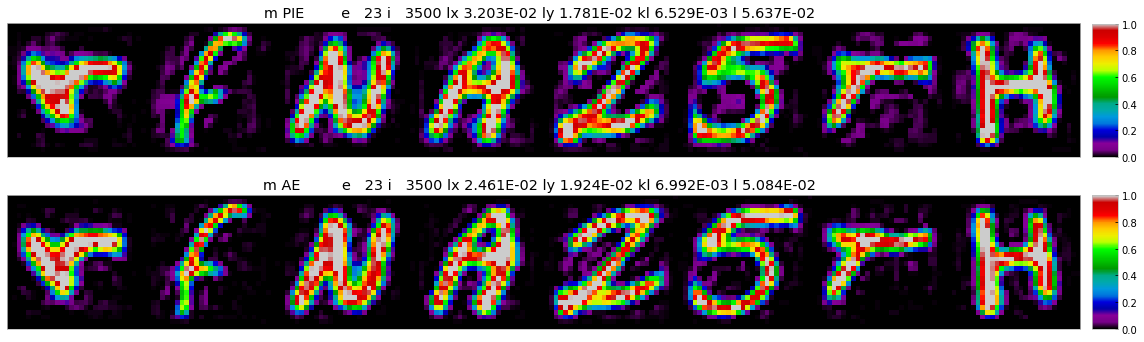

In [10]:
# Training loop

for e in range(epochs):
    i = 0
    for x, y in loader:
        x = x.to(device)
        y = index_matrix[y]
        xhs = {}
        ldicts = {}
        for m, cur in enumerate(nets):
            # Reset gradients and do forward pass
            opts[cur].zero_grad()
            yh, z, yz, S, mu, lv = nets[cur](x)
            xh = nets[cur].T(yh, z, yz, S=S)
            
            if torch.any(torch.isnan(xh)):
                print(torch.sum(torch.isnan(xh)))
                raise ValueError('NAN values computed. Aborting.')

            # Calculate loss
            loss, ldicts[cur] = objective_function(x, xh, y, yh, mu, lv)

            loss.backward()
            opts[cur].step()
            
#             # Validation
#             with torch.no_grad():
#                 yt, _mu, _lv = nets[cur](xt, sample=False)
#                 xth = nets[cur].T(yt)
#                 ldicts[cur]['lt'] = F.mse_loss(xth, xt, reduction='mean')

            # Reporting
            for k, v in ldicts[cur].items():
                
                if k not in loss_trace[cur]:
                    loss_trace[cur][k] = []

                loss_trace[cur][k].append(v.item())


        # Plot and Report
        if i % 50 == 0:
            for cur in nets.keys():
                with torch.no_grad():
                    yh, z, yz, S, mu, lv = nets[cur](xs, sample=True)
                    xhs[cur] = nets[cur].T(yh, z, S=S)
                    xhs[cur] = xhs[cur].to('cpu')[:,0,...]
            clear_output(wait=True)
            utils.reporting.plot_training(xhs, e, i, ldicts, path=experiment_name)
            
        i += 1

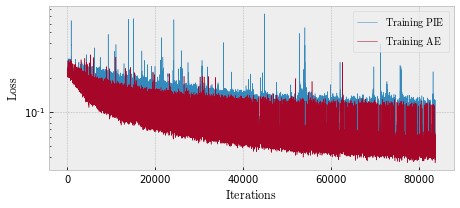

In [11]:
# Convert trace to numpy
np_loss_trace = {}
for k in loss_trace:
    np_loss_trace[k] = {}
    for l in loss_trace[k]:
        np_loss_trace[k][l] = np.array([v for v in loss_trace[k][l]])

# Plot overall loss
for k in nets.keys():
    ws = 1001
    mu, std = utils.metrics.rolling_stats(np_loss_trace[k]["l"], winsize=ws) 
    p = plt.plot(
        np_loss_trace[k]["l"][ws//2:-ws//2], 
        linewidth=.5, 
        label=f"$\mathrm{{Training\,\,{k}}}$", 
        alpha=1, 
    )
    color = p[0].get_color()
    # plt.fill_between(
    #     np.arange(len(mu[ws//2:-ws//2])), 
    #     (mu - 1.5*std)[ws//2:-ws//2], 
    #     (mu + 1.5*std)[ws//2:-ws//2],
    #     color=color, 
    #     alpha=0.2,
    # )    

plt.legend()
plt.xlabel('$\mathrm{Iterations}$')
plt.ylabel('$\mathrm{Loss}$')
plt.yscale("log")
#plt.ylim(1.5e-2, 1e-1)
plt.savefig(f'../figures/training/{experiment_name}.pdf')

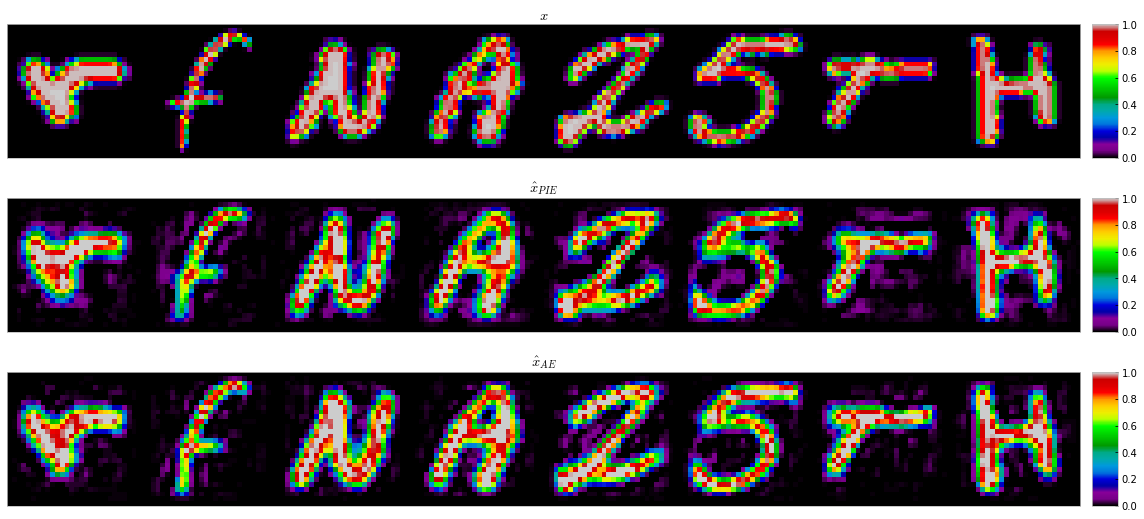

In [12]:
# Plot results
with torch.no_grad():
    xhs = {"": xims}
    
    for cur in nets.keys():
        yh, z, yz, S, mu, lv = nets[cur](xs, sample=False)
        xhs[cur] = nets[cur].T(yh, z, S=S)
        xhs[cur] = xhs[cur].to('cpu')[:,0,...]
    
utils.reporting.plot_results(xhs, f'', fname=experiment_name)

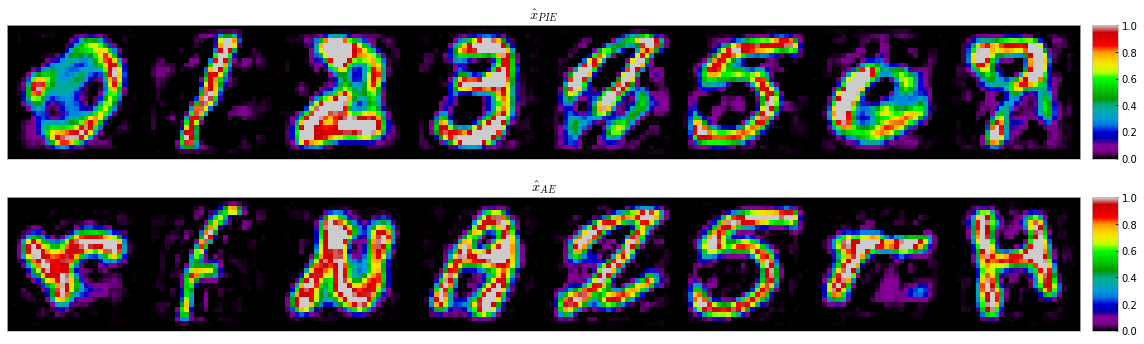

In [13]:
xhs = {}
# Plot results
with torch.no_grad():    
    for cur in nets.keys():
        yh, z, yz, S, mu, lv = nets[cur](xs, sample=False)
        yh = index_matrix[torch.arange(8)] - index_matrix[torch.arange(8)]*0.01
        xhs[cur] = nets[cur].T(yh, z, S=S)
        xhs[cur] = xhs[cur].to('cpu')[:,0,...]
    
utils.reporting.plot_results(xhs, f'', fname=experiment_name + '_synth_y')

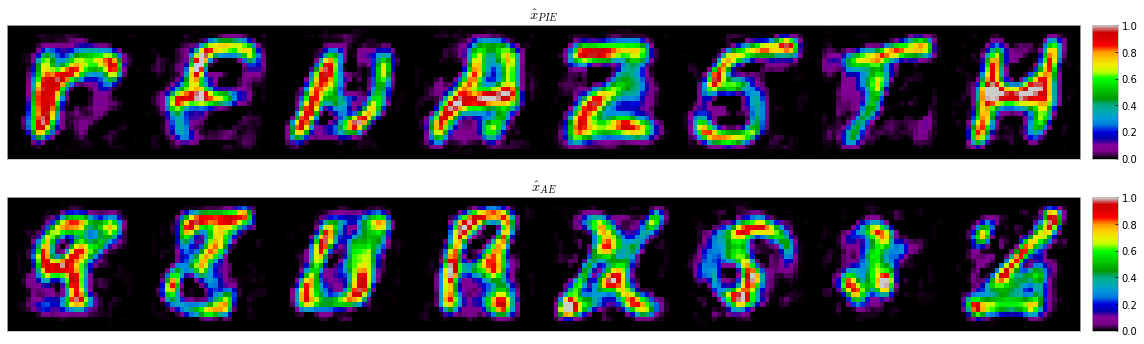

In [14]:
xhs = {}

# Plot results
with torch.no_grad():
    for cur in nets.keys():
        yh, z, yz, S, mu, lv = nets[cur](xs, sample=False)
        z = torch.randn_like(z)
        xhs[cur] = nets[cur].T(yh, z, S=None)
        xhs[cur] = xhs[cur].to('cpu')[:,0,...]
    
utils.reporting.plot_results(xhs, f'', fname=experiment_name + '_synth_z')

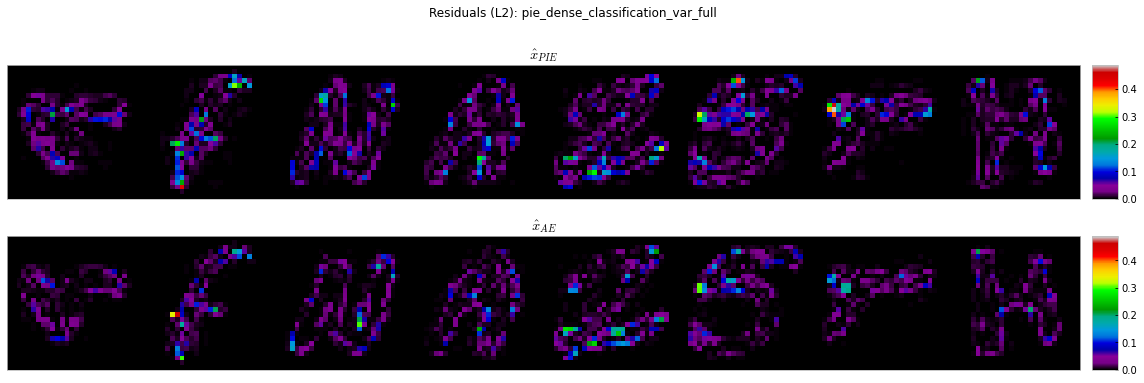

In [15]:
# Plot residuals (L2)
with torch.no_grad():
    xhs = {}
    curmax = 0

    for cur in nets.keys():
        yh, z, yz, S, mu, lv = nets[cur](xs, sample=False)        
        xhs[cur] = nets[cur].T(yh, z, S=S)
        xhs[cur] = xhs[cur].to('cpu')[:,0,...]
        xhs[cur] = (xhs[cur] - xims)**2
        if torch.max(xhs[cur]) > curmax:
            curmax = torch.max(xhs[cur])

utils.reporting.plot_results(
    xhs, f'Residuals (L2): {experiment_name}', vmax=curmax, fname=experiment_name + 'res', root='../figures/results/'
)

In [16]:
# Move models to CPU
for cur, model in nets.items():
    nets[cur] = model.to('cpu')
    del model
    
torch.cuda.empty_cache()

In [17]:
# Calculate relative error on test data
test_tensor = torch.tensor(test.data).float()[:,None,...] / 255
print(f"Relative Error:")

for k, model in nets.items():
    yh, z, yz, _, _, _ = model(test_tensor, sample=False)
    XH = model.T(yh, z, yz)
    yt = index_matrix.cpu()[test.targets]
    print(
        f"{k:6}: " + 
        f"RE {utils.metrics.relative_error(test_tensor, XH, reduction='mean'):4E} " +
        f"MSE {F.mse_loss(test_tensor, XH, reduction='mean'):4E} " +
        f"Acc {utils.metrics.top_k_accuracy(yh, yt, k=1):4E} " +
        f"Ac5 {utils.metrics.top_k_accuracy(yh, yt):4E} "
    )

# Clear memory
del XH, yz, z

Relative Error:
PIE   : RE 5.876859E-01 MSE 1.123497E-02 Acc 8.358511E-01 Ac5 9.812766E-01 
AE    : RE 4.622131E-01 MSE 8.229563E-03 Acc 8.293617E-01 Ac5 9.780851E-01 


In [18]:
index_matrix.cpu()[test.targets]

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [19]:
import gc

gc.collect();

In [20]:
# Calculate PSNR and SSIM on test data
print(f"Image Reconstruction Metrics:")
for k, model in nets.items():
    yh, z, yz, _, _, _ = model(test_tensor, sample=False)
    XH = model.T(yh, z, yz)
    psnr = utils.metrics.psnr(test_tensor, XH)
    ssim = utils.metrics.ssim(
        test_tensor, 
        XH
    )
    print(
        f"{k:6}: " + 
        f"PSNR {psnr:4E} " +
        f"SSIM {ssim:4E} "
    )

# Clear memory
del XH, yh, yz, z
gc.collect();

Image Reconstruction Metrics:
PIE   : PSNR 1.949412E+01 SSIM 7.751809E-01 
AE    : PSNR 2.084620E+01 SSIM 8.810509E-01 


In [21]:
print(f"KL Divergence:")
for name, model in nets.items():
    op = model(test_tensor, sample=False)
    mu, lv = op[-2:]
    kl = utils.loss.kl_divergence(mu, lv, 'mean', len(test))
    print(
        f"{name:6}: " + 
        f"KL {kl:4E} "
    )

KL Divergence:
PIE   : KL 4.678231E-01 
AE    : KL 4.873040E-01 


`
KL Divergence:
PIE   : KL 2.649782E-01
AE    : KL 3.368094E-01 
`

In [22]:
# Move models to GPU
for k in nets:
    nets[k] = nets[k].to(device)

# Estimate Condition Number using Adverserial Perturbation
rs = {}
opts_p = {}
epochs = 3
loss_trace_p = {}
for k in nets.keys():
    loss_trace_p[k] = {'l': [], 'lphi_x': [], 'lphi_y': []}
    rs[k] = nn.Parameter(torch.randn(1, 28, 28).to(device))
    _zs = torch.sum(rs[k] == 0)
    while _zs > 0:
        rs[k][rs[k] == 0] = nn.Parameter(torch.random.randn(_zs))
        _zs = torch.sum(rs[k] == 0)
    nets[k].eval()
    opts_p[k] = torch.optim.Adam([rs[k]])

In [23]:
# Define Perturbation Objective
def perturbation_objective(xe, xh, ye, yh):
    losses = {}
    
    lphi_x = -F.mse_loss(xe, xh)
    lphi_y = -F.mse_loss(ye, yh)
    losses['lphi_x'] = lphi_x
    losses['lphi_y'] = lphi_y

    return sum(losses.values()), losses

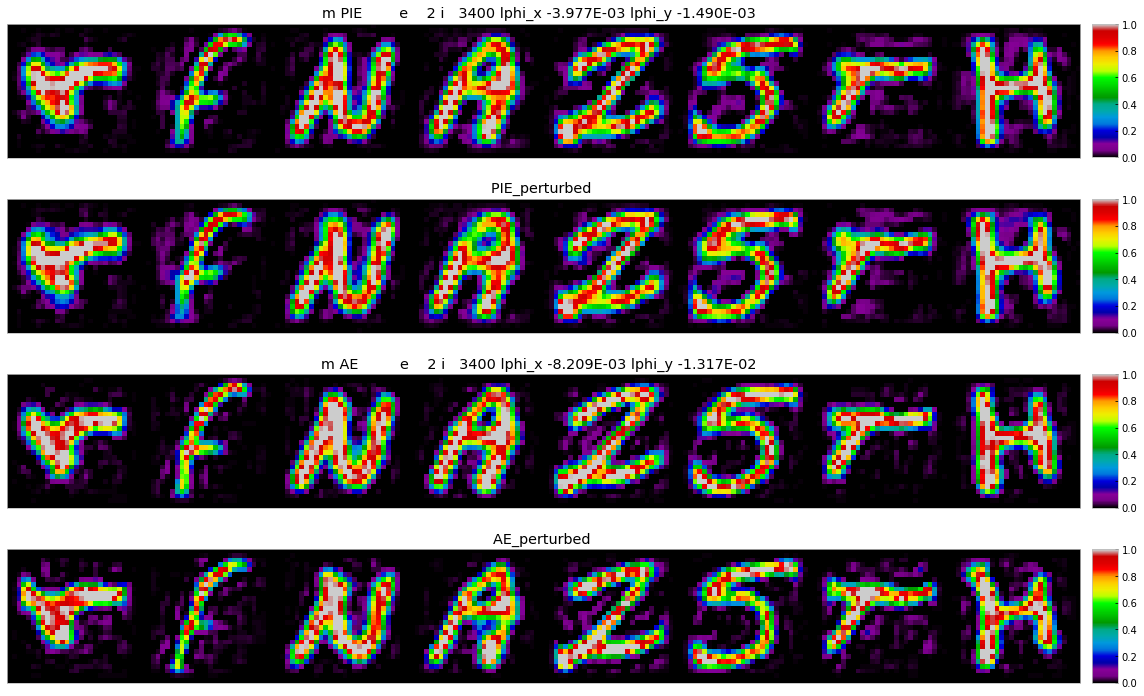

In [24]:
# Training loop

for e in range(epochs):
    i = 0
    for x, y in loader:
        x = x.to(device)
        y = index_matrix[y]
        xhs = {}
        ldicts = {}
        for m, cur in enumerate(nets):
            # Reset gradients and do forward pass
            r = utils.projection.project_into_ball(rs[cur].flatten(-3, -1), 1, 2).unflatten(-1, (1, 28, 28))
            opts[cur].zero_grad()
            yh, z, yz, _, _, _ = nets[cur](x, sample=False)
            xh = nets[cur].T(yh, z, yz)
            ye, z, yz, _, _, _ = nets[cur](x + r, sample=False)
            xe = nets[cur].T(yh, z, yz)

            # Calculate loss
            loss, ldicts[cur] = perturbation_objective(xe, xh, ye, yh)

            loss.backward()
            opts_p[cur].step()
            
            # Reporting
            for k, v in ldicts[cur].items():
                
                if k not in loss_trace_p[cur]:
                    loss_trace[cur][k] = []

                loss_trace_p[cur][k].append(v)


        # Plot and Report
        if i % 200 == 0:
            xhs = {}
            for cur in nets.keys():
                with torch.no_grad():
                    per = f'{cur}_perturbed'
                    r = utils.projection.project_into_ball(rs[cur].flatten(-3, -1), 1, 2).unflatten(-1, (1, 28, 28))

                    yh, z, yz, S, mu, lv = nets[cur](xs, sample=False)
                    xhs[cur] = nets[cur].T(yh, z, S=S)
                    xhs[cur] = xhs[cur].to('cpu')[:,0,...]

                    yh, z, yz, S, mu, lv = nets[cur](xs + r, sample=False)
                    xhs[per] = nets[cur].T(yh, z, S=S)
                    xhs[per] = xhs[per].to('cpu')[:,0,...]
                    
            clear_output(wait=True)
            utils.reporting.plot_training(xhs, e, i, ldicts, save=False)            
        i += 1

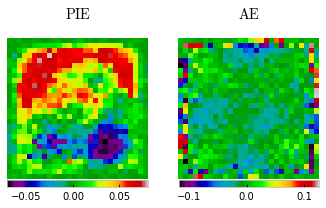

In [25]:
fig, ax = plt.subplots(1, 2)
for i, cur in enumerate(nets):
    r = utils.projection.project_into_ball(rs[cur].flatten(-3, -1), 1, 2).unflatten(-1, (1, 28, 28))    
    plot = ax[i].matshow(r[0].detach().cpu())
    plt.colorbar(plot, ax=ax[i], location='bottom', fraction=0.047, pad=0.01)
    ax[i].set_title(f'$\mathrm{{{cur}}}$')
    
for a in ax:
    a.grid(False)
    a.axis('off')
    
plt.savefig(f'../figures/misc/{experiment_name}_perturbationvecs.pdf')

In [26]:
# Move models to CPU
for cur, model in nets.items():
    nets[cur] = model.to('cpu')

# Calculate relative error
print(f"Relative Cond:")

for k, model in nets.items():
    r = utils.projection.project_into_ball(rs[cur].flatten(-3, -1), 1, 2).unflatten(-1, (1, 28, 28))
    XE = model.T(*model(test_tensor + r.cpu(), sample=False)[:3])
    XH = model.T(*model(test_tensor, sample=False)[:3])

    f = nn.Flatten(-3, -1)
    rerr_psi = utils.metrics.relative_error(f(XH), f(XE), reduction='mean')
    rerr_x = utils.metrics.relative_error(f(test_tensor), f(test_tensor + r.cpu()), reduction='mean')
    cond_no = utils.metrics.relative_cond_no(f(XH), f(XE), f(test_tensor), f(r.cpu()), reduction='mean')
    
    print(f"{k:6}: {rerr_psi.item():2.6f} {rerr_x.item():2.6f} {cond_no.item():2.6f}")

Relative Cond:
PIE   : 0.051218 0.098739 2.088172
AE    : 0.266634 0.098739 10.870659


In [27]:
# Save models

serialized_path = f'../serialized/experiments/{experiment_name}/'
if not os.path.isdir(serialized_path):
    os.mkdir(serialized_path)

for name, model in nets.items():
    with open(f'{serialized_path}{name}.pt', 'wb') as outfile:
        torch.save(model, outfile)

In [28]:
# Save training results

with open(f'{serialized_path}training.pickle', 'wb') as outfile:
    pickle.dump(np_loss_trace, outfile)

In [10]:
# Load models

serialized_path = f'../serialized/experiments/{experiment_name}/'
for name, model in nets.items():
    with open(f'{serialized_path}{name}.pt', 'rb') as outfile:
        nets[name] = torch.load(outfile)

In [11]:
# Move models to GPU
for k in nets:
    nets[k] = nets[k].to(device)

utils.rng.set_seed(42)

# Estimate Condition Number using Adverserial Perturbation
rs = {}
opts_p = {}
epochs = 3
loss_trace_p = {}
for k in nets.keys():
    loss_trace_p[k] = {'l': [], 'lphi_x': [], 'lphi_y': []}
    rs[k] = nn.Parameter(torch.randn(784).to(device))
    _zs = torch.sum(rs[k] == 0)
    while _zs > 0:
        rs[k][rs[k] == 0] = nn.Parameter(torch.random.randn(_zs))
        _zs = torch.sum(rs[k] == 0)
    nets[k].eval()
    opts_p[k] = torch.optim.Adam([rs[k]])

In [12]:
# Define Perturbation Objective
def perturbation_objective(xe, xh):
    losses = {}
    
    lphi_x = -F.mse_loss(xe, xh)
    losses['lphi_x'] = lphi_x

    return sum(losses.values()), losses

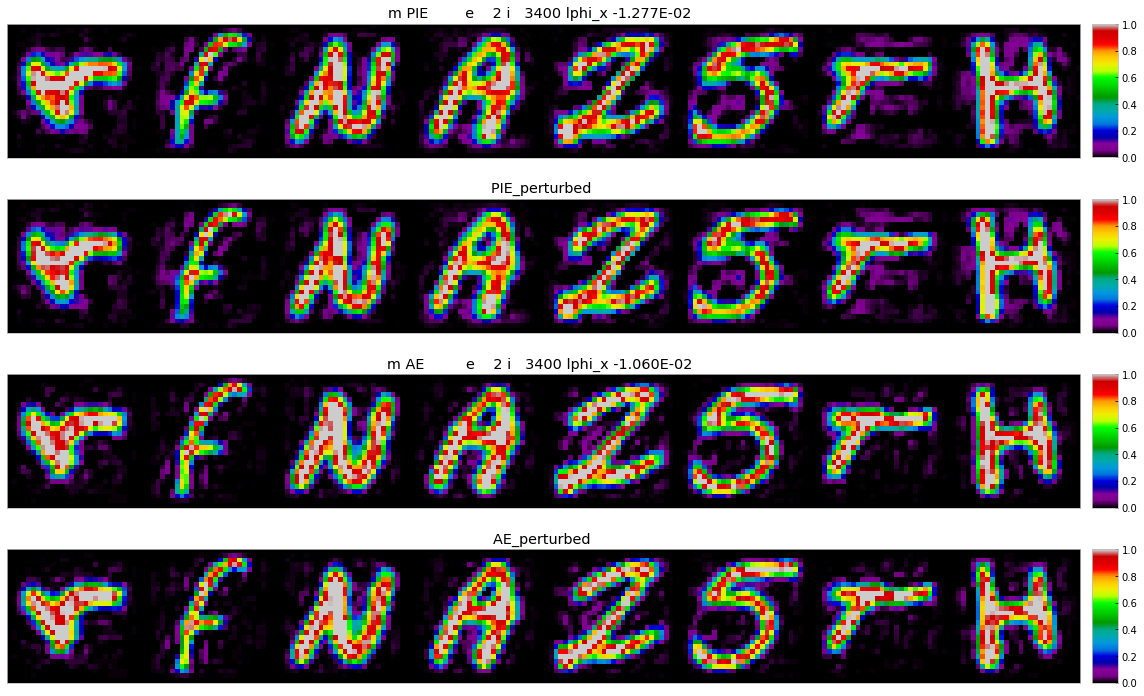

In [13]:
# Training loop

for e in range(epochs):
    i = 0
    for x, y in loader:
        x = x.to(device)
        y = index_matrix[y]
        xhs = {}
        ldicts = {}
        for m, cur in enumerate(nets):
            # Reset gradients and do forward pass
            r = utils.projection.project_into_ball(rs[cur], 1, 2)
            opts[cur].zero_grad()
            yh, z, yz, _, _, _ = nets[cur](x, sample=False)
            xe = nets[cur].T(yh, z + r[yz.shape[-1]:], yz + r[:yz.shape[-1]])

            # Calculate loss
            loss, ldicts[cur] = perturbation_objective(xe, x)

            loss.backward()
            opts_p[cur].step()
            
            # Reporting
            for k, v in ldicts[cur].items():
                
                if k not in loss_trace_p[cur]:
                    loss_trace[cur][k] = []

                loss_trace_p[cur][k].append(v)


        # Plot and Report
        if i % 200 == 0:
            xhs = {}
            for cur in nets.keys():
                with torch.no_grad():
                    per = f'{cur}_perturbed'
                    r = utils.projection.project_into_ball(rs[cur], 1, 2)

                    yh, z, yz, S, mu, lv = nets[cur](xs, sample=False)
                    xhs[cur] = nets[cur].T(yh, z, yz)
                    xhs[cur] = xhs[cur].to('cpu')[:,0,...]
                    xhs[per] = nets[cur].T(yh, z + r[yz.shape[-1]:], yz + r[:yz.shape[-1]])
                    xhs[per] = xhs[per].to('cpu')[:,0,...]
                    
            clear_output(wait=True)
            utils.reporting.plot_training(xhs, e, i, ldicts, save=False)            
        i += 1

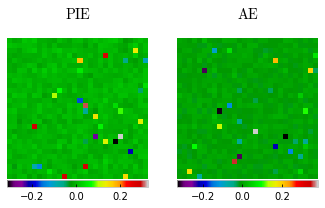

In [14]:
fig, ax = plt.subplots(1, 2)
for i, cur in enumerate(nets):
    r = utils.projection.project_into_ball(rs[cur], 1, 2).unflatten(-1, (1, 28, 28))
    plot = ax[i].matshow(r[0].detach().cpu())
    plt.colorbar(plot, ax=ax[i], location='bottom', fraction=0.047, pad=0.01)
    ax[i].set_title(f'$\mathrm{{{cur}}}$')
    
for a in ax:
    a.grid(False)
    a.axis('off')
    
plt.savefig(f'../figures/misc/{experiment_name}_perturbationvecs_y.pdf')

In [22]:
# Move models to CPU
for cur, model in nets.items():
    nets[cur] = model.to('cpu')

# Calculate relative error
print(f"Relative Cond:")

for k, model in nets.items():
    
    r = utils.projection.project_into_ball(rs[cur], 1, 2).cpu()
    yh, z, yz, S, mu, lv = nets[cur](xt[:,None,...].cpu(), sample=False)
    XH = nets[cur].T(yh, z, yz)
    XE = nets[cur].T(yh, z + r[yz.shape[-1]:], yz + r[:yz.shape[-1]])

    f = nn.Flatten(-3, -1)
    cond_no = utils.metrics.relative_cond_no(f(XH), f(XE), f(xt[:,None,...].cpu()), r.cpu(), reduction='mean')
    
    print(f"{k:6}: {cond_no.item():2.6f}")

Relative Cond:
PIE   : 4.962300
AE    : 4.962317
